In [159]:
import pandas as pd
import numpy as np
import glob
import nibabel as nib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

In [185]:
def grab_stat_files(dir:str):
    # Set directory containing the contrast files
    dir = dir
    # Get list of all .nii.gz files in the directory
    files = glob.glob(dir)
    # Exclude those with missing scans or dprime values (2.81)
    files = [f for f in files if all(x not in f for x in ['028', '521', '522'])]
    # Exclude those with missing scans or dprime values (3.29)
    # files = [f for f in files if all(x not in f for x in ['005', '025', '028', '521', '522'])]
    # Separate files into HC and SCZ groups based on filename prefixes
    HC = []
    SCZ = []
    for f in files: 
        if f.split('/')[-1].startswith('0'):
            HC.append(f)
        if f.split('/')[-1].startswith('5'):
            SCZ.append(f)
    # Sort the lists to maintain consistent order
    print(len(HC), len(SCZ))
    return sorted(HC), sorted(SCZ)

In [186]:
c = 'contrast-2v0'
thr = 'thr2.81'
thr_hc, thr_scz = grab_stat_files(f'/BICNAS2/tuominen/ANM2_SCZ/anm_files/fz_maps/{c}/{thr}/Fz-maps/*.nii.gz')

34 22


In [187]:
def extract_pca_values(file_list):
    pca_values = []
    for file in file_list:
        img = nib.load(file)
        data = img.get_fdata()
        flattened_data = data.flatten()
        #print(flattened_data.shape)
        pca_values.append(flattened_data)
        X = np.vstack(pca_values)
    return X

In [188]:
pca_array = extract_pca_values(thr_hc + thr_scz)

In [189]:
pca_array.shape

(56, 902629)

In [191]:
dprime_df = pd.read_csv('/BICNAS2/tuominen/ANM2_SCZ/code/2back_dprime_allsubjects.csv', index_col=0)
# Filter to match subjects in your fMRI data (excluding 028 and 521, 522)
dprime_df = dprime_df[~dprime_df['Subject'].isin([28, 521, 522])]
# Exclude patients
#dprime_df = dprime_df.loc[dprime_df['Subject'] < 500]
# Sort by subject to match the order of your fMRI files
dprime_df = dprime_df.sort_values('Subject').reset_index(drop=True)
print(len(dprime_df.Subject.unique()))

56


In [193]:
# Extract d-prime values as the behavioral outcome variable
y_behavior = dprime_df['n_hit'].values + dprime_df['n_cr'].values
print(f"Number of subjects: {len(y_behavior)}")
print(f"y_behavior shape: {y_behavior.shape}")

Number of subjects: 56
y_behavior shape: (56,)


In [194]:
# Ensure y is a numpy array
y_behavior = np.array(y_behavior)

In [195]:
# The paper searched alphas from 10^-5 to 10^5 in logarithmic steps
alphas = np.logspace(-5, 5, 11)

In [197]:
outer_cv = LeaveOneOut()
y_pred_all, y_true_all = [], []
coefficients_all = []
pca_loadings_all = []   # optional, if you want projection back

for fold, (train_index, test_index) in enumerate(outer_cv.split(pca_array), start=1):
    X_train, X_test = pca_array[train_index], pca_array[test_index]
    y_train, y_test = y_behavior[train_index], y_behavior[test_index]

    model = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("ridge", RidgeCV(alphas=alphas, cv=LeaveOneOut(), scoring="neg_mean_squared_error"))
    ])

    model.fit(X_train, y_train)
    pred = model.predict(X_test)[0]

    y_pred_all.append(pred)
    y_true_all.append(y_test[0])

    ridge = model.named_steps["ridge"]
    pca = model.named_steps["pca"]

    coefficients_all.append(ridge.coef_)         # in PCA space
    pca_loadings_all.append(pca.components_)     # to map back later (fold-specific!)

    print(f"Fold {fold}: best alpha = {ridge.alpha_}")

y_pred_all = np.array(y_pred_all)
y_true_all = np.array(y_true_all)


Fold 1: best alpha = 100000.0
Fold 2: best alpha = 100000.0
Fold 3: best alpha = 100000.0
Fold 4: best alpha = 100000.0
Fold 5: best alpha = 100000.0
Fold 6: best alpha = 100000.0
Fold 7: best alpha = 100000.0
Fold 8: best alpha = 100000.0
Fold 9: best alpha = 100000.0
Fold 10: best alpha = 100000.0
Fold 11: best alpha = 100000.0
Fold 12: best alpha = 100000.0
Fold 13: best alpha = 100000.0
Fold 14: best alpha = 100000.0
Fold 15: best alpha = 100000.0
Fold 16: best alpha = 100000.0
Fold 17: best alpha = 100000.0
Fold 18: best alpha = 100000.0
Fold 19: best alpha = 100000.0
Fold 20: best alpha = 100000.0
Fold 21: best alpha = 100000.0
Fold 22: best alpha = 100000.0
Fold 23: best alpha = 100000.0
Fold 24: best alpha = 100000.0
Fold 25: best alpha = 100000.0
Fold 26: best alpha = 100000.0
Fold 27: best alpha = 100000.0
Fold 28: best alpha = 100000.0
Fold 29: best alpha = 100000.0
Fold 30: best alpha = 100000.0
Fold 31: best alpha = 100000.0
Fold 32: best alpha = 100000.0
Fold 33: best alp

In [198]:
print("R^2:", r2_score(y_true_all, y_pred_all))
print("r:", np.corrcoef(y_true_all, y_pred_all)[0, 1])

R^2: -0.2917567545962241
r: -0.20370753959799107


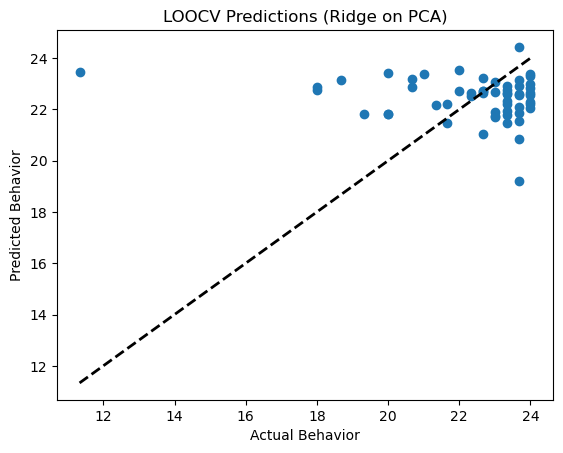

In [199]:
import matplotlib.pyplot as plt
plt.scatter(y_true_all, y_pred_all) 
plt.plot([y_true_all.min(), y_true_all.max()], [y_true_all.min(), y_true_all.max()], 'k--', lw=2) # Identity line 
plt.xlabel('Actual Behavior') 
plt.ylabel('Predicted Behavior') 
plt.title('LOOCV Predictions (Ridge on PCA)') 
plt.show()